In [74]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd
from itertools import cycle
import torchvision
from PIL import Image

sns.set_theme(style="white",palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [75]:
audio_files_path = glob('./data/*/*/*.wav')     #用glob獲得檔案
ipd.Audio(audio_files_path[0])

In [76]:
y_list=[]
sr_list=[]
for audio_file in audio_files_path:
    y_list.append(librosa.load(audio_file)[0])   #音檔相對振幅
    sr_list.append(librosa.load(audio_file)[1])  #sample_rate 採樣頻率
#print('y.type: ',type(y),'\t','sample rate: ',sr)
print('number of datas: ',len(y_list))

number of datas:  456


將音檔無聲部分剪除，並把音檔長度固定

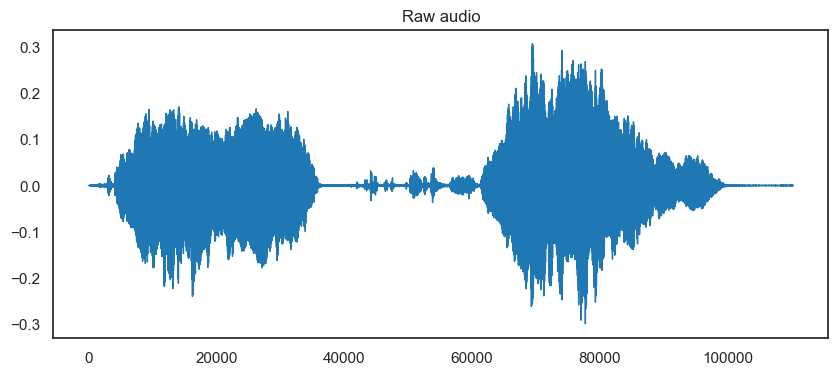

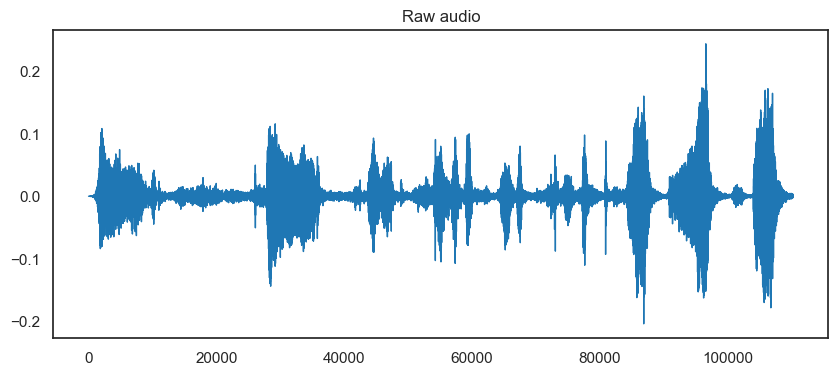

In [77]:
y_trimmed_list = []     #
sr = sr_list[0]
target_length = 5 * sr #目標音檔長度
for y in y_list:
        y_trimmed, _ = librosa.effects.trim(y,top_db=60)        #設定閾值80 
        if len(y_trimmed)>target_length:
                y_trimmed =  y_trimmed[:target_length]
        y_trimmed_list.append(y_trimmed)
for i  in range(2):
    pd.Series( y_trimmed_list[i]).plot(figsize=(10,4),lw=1,title='Raw audio',color=color_pal[0])
    plt.show()

製作label=0的音檔(ECS)

In [78]:
ECS_files_path  = glob('./audio/*.wav')
#ipd.Audio(ECS_files_path[1])       #聽音檔
y0_list=[]
sr0_list=[]
for ECS_file in ECS_files_path:
    y0_list.append(librosa.load(ECS_file)[0])   #音檔振幅
    sr0_list.append(librosa.load(ECS_file)[1])  #sample_rate
#for i in range(len(y0_list)):           
#   if len(y0_list[i])!=110250:     #全部是5秒音檔
#      print('no')

傅立葉轉換成可丟進CNN的圖檔

In [79]:
'''#stft加上振幅轉分貝
S_db_list = []
for y_trimmed in y_trimmed_list:
    D = librosa.stft(y_trimmed)
    S_db = librosa.amplitude_to_db(np.abs(D),ref=np.max)
    S_db_list.append(S_db)'''

'#stft加上振幅轉分貝\nS_db_list = []\nfor y_trimmed in y_trimmed_list:\n    D = librosa.stft(y_trimmed)\n    S_db = librosa.amplitude_to_db(np.abs(D),ref=np.max)\n    S_db_list.append(S_db)'

In [80]:

'''for i in range(5):
    fig, ax = plt.subplots(figsize=(10,5))
    img = librosa.display.specshow(S_db_list[i],
                                   x_axis='time',
                                   y_axis='log',
                                   ax=ax
                                   )
    ax.set_title('Spectogram Example', fontsize=20)
    fig.colorbar(img,ax=ax, format=f'%0.2f')
    plt.show()'''

"for i in range(5):\n    fig, ax = plt.subplots(figsize=(10,5))\n    img = librosa.display.specshow(S_db_list[i],\n                                   x_axis='time',\n                                   y_axis='log',\n                                   ax=ax\n                                   )\n    ax.set_title('Spectogram Example', fontsize=20)\n    fig.colorbar(img,ax=ax, format=f'%0.2f')\n    plt.show()"

用mel_spectogram轉成人類可聽音檔圖片

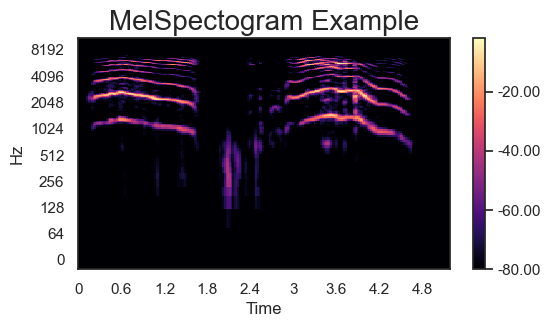

In [81]:

S_list = []
S_db_mel_list = []
num_channels = 3 #指定圖片輸入通道數

for i in range(len(y_trimmed_list)):        #轉換成梅爾頻譜圖
        S = librosa.feature.melspectrogram(y=y_trimmed_list[i],
                                           sr=sr_list[i],
                                           n_mels=216)
        S_list.append(S)
        S_db_mel = librosa.amplitude_to_db(S,ref=np.max)    #把音檔從振幅轉成分貝
        S_db_mel = np.asarray(torchvision.transforms.Resize((224, 224))(Image.fromarray(S_db_mel)))
        S_db_mel_list.append(S_db_mel)
        
for i  in range(1):             #印出梅爾頻譜圖
    fig, ax = plt.subplots(figsize=(6,3))
    img = librosa.display.specshow(S_db_mel_list[i],
                                   x_axis='time',
                                   y_axis='log',
                                   ax=ax
                                  )
    ax.set_title('MelSpectogram Example', fontsize=20)
    fig.colorbar(img,ax=ax, format=f'%0.2f')
    plt.show()   

In [82]:
hop_size = [128,256,512]
win_size = [100,200,400]
S_db_channels_list = []
for i in range(len(y_trimmed_list)):        #轉換成梅爾頻譜圖
    S_db_channels = []
    for j in range(num_channels):
        S = librosa.feature.melspectrogram(y=y_trimmed_list[i],
                                           sr=sr_list[i],
                                           hop_length = hop_size[j],
                                           win_length=win_size[j]
                                           )
        S_db_mel = librosa.amplitude_to_db(S,ref=np.max)    #把音檔從振幅轉成分貝
        S_db_mel = np.asarray(torchvision.transforms.Resize((224, 224))(Image.fromarray(S_db_mel)))
        S_db_channels.append(S_db_mel)                          
    S_db_channels_arr = np.array(S_db_channels)
    S_db_channels_list.append( S_db_channels_arr)
print(S_db_channels_list[0].shape)      #一個list，每個元素是3*224*224的梅爾頻譜圖 數據集

(3, 224, 224)


將頻譜圖大小限制在216*216

In [83]:
for  i in range(len(y_list)):
    #print(S_db_mel_list[i].shape)
    if S_db_mel_list[i].shape[1]<216:
        print(audio_files_path[i])

製作ECS(label=0)的mel_spectogram

In [84]:
hop_size = [128,256,512]
win_size = [100,200,400]
S0_db_channels_list = []
for i in range(len(y0_list)):        #轉換成梅爾頻譜圖
    S0_db_channels = []
    for j in range(num_channels):
        S0 = librosa.feature.melspectrogram(y=y0_list[i],
                                           sr=sr0_list[i],
                                           hop_length = hop_size[j],
                                           win_length=win_size[j]
                                           )
        S0_db_mel = librosa.amplitude_to_db(S0,ref=np.max)    #把音檔從振幅轉成分貝
        S0_db_mel = np.asarray(torchvision.transforms.Resize((224, 224))(Image.fromarray(S0_db_mel)))
        S0_db_channels.append(S0_db_mel)                          
    S0_db_channels_arr = np.array(S0_db_channels)
    S0_db_channels_list.append( S0_db_channels_arr)
print(S0_db_channels_list[0].shape)      #一個list，每個元素是3*224*224的梅爾頻譜圖 數據集

(3, 224, 224)


合併成數據集

In [85]:
dataset = []

for  i in range(len(y_list)):                       #label=1放入 456筆
    new_entry = {}
    new_entry['values'] = S_db_channels_list[i]
    new_entry['target'] = 1
    new_entry['audio'] = y_list[i]
    dataset.append(new_entry)

for  i in range(len(y0_list)):                      #label=0放入 411筆
    new_entry = {}
    new_entry['values'] = S0_db_channels_list[i]
    new_entry['target'] = 0
    new_entry['audio'] = y0_list[i]
    dataset.append(new_entry)

len(dataset)

867

In [86]:
type(dataset[0]['values'])


numpy.ndarray

完成1個channel梅爾頻譜圖的數據集(label=1，values是時頻圖(大小為216*216)，audio是音檔振幅array)

Dataset類別

In [87]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
import torch

#切割訓練集、測試集
featureset =[entry['values'] for entry in dataset]
targetset = [entry['target'] for entry in dataset]
X_train, X_test, Y_train, Y_test = train_test_split(featureset,targetset,test_size=0.2,random_state=42)
from torch.utils.data import Dataset

class AudioDataset(Dataset):
    def __init__(self, features, targets):  #輸入切分數據集的特徵和標籤
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)   #返回資料集長度

    def __getitem__(self, idx):     #返回梅爾頻譜圖和標籤
        feature = self.features[idx]
        target = self.targets[idx]
        return feature, target

trainset = AudioDataset(X_train,Y_train) 
testset = AudioDataset(X_test,Y_test) 
train_Loader = DataLoader(trainset,batch_size=32,shuffle=True,num_workers=2)
test_Loader = DataLoader(testset,batch_size=32,shuffle=False,num_workers=2)


In [88]:
trainset.__getitem__(15)[0].shape

(3, 224, 224)

建立模型(使用預訓練的densenet作微調)

In [89]:

import torch
import torch.nn as nn
from torchvision import models
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        num_classes = 2     #二元分類
        self.model = models.densenet121(pretrained=True) #選用densenet121
        num_features = self.model.classifier.in_features       #取得classfier層的輸入
        self.model.classifier = nn.Linear(num_features, num_classes)    #修改成自己的分類
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        output = self.model(x)
        output = self.softmax(output)
        return output

訓練模型

In [90]:
import tqdm
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
net = DenseNet() #desnet作二元分類
criterion = nn.CrossEntropyLoss()               #loss function
optimizer= optim.SGD(net.parameters(),lr=0.001,momentum=0.9)  #設定優化方法(提供模型參數、學習率、momentum幫助沖出local minimum)

def train_model(model,dataloader,lossfn,optimizer):  #模型訓練
    epochs = 10
    model.train()
    for epoch in range(epochs):        #跑epoch
        running_loss = 0.0      #紀錄loss
        with tqdm(total=len(dataloader)) as t:  #做進度條
                
            for i, data in enumerate(train_Loader, 0):      #enumerate用於將一個可遍歷的數列作編號，0表示從0開始編
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                # zero the parameter gradients 讓梯度先歸零，才能作下次計算
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = lossfn(outputs, labels)
                loss.backward()
                optimizer.step()
                t.update()
                # print statistics
                running_loss += loss.item() ##加上損失函數
                if i % 200 == 199:    # print every 200 mini-batches
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
                    running_loss = 0.0
    model.eval()
    print('Finished Training')

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [91]:
class AudioDataset(Dataset):
    if __name__ == "__main__":
        train_Loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)


In [92]:
PATH = './densenet.pth'
torch.save(net.state_dict(), PATH)

In [93]:
train_Loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)
test_Loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

dataiter = iter(test_Loader)
images, labels = next(dataiter)

net = DenseNet()
net.load_state_dict(torch.load(PATH))

outputs = net(images)


In [94]:
k=[]
acc = 0.
total = 0.
for output in outputs:
    if output[0]>output[1]:
        k.append(0)
    else:
        k.append(1)
for i in range(len(labels)):
    if k[i] == labels[i].item():
        acc+=1
    total+=1
print('accuracy: ',acc/total)
    

accuracy:  0.625
